In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import scanpy as sc
import torch
import lineagevi

In [4]:
adata_path = '/Users/lgolinelli/git/lineageVI/notebooks/data/outputs/pancreas_2025.08.17_12.43.17/adata_with_velocity.h5ad'
model_path = '/Users/lgolinelli/git/lineageVI/notebooks/data/outputs/pancreas_2025.08.17_12.43.17/vae_velocity_model.pt'

adata = sc.read_h5ad(adata_path)

model = lineagevi.trainer.LineageVI(
    adata,
)

model.load_state_dict(torch.load(model_path, map_location='cpu'))
model.eval()


LineageVI(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=1805, out_features=128, bias=True)
      (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
    )
    (mean_layer): Linear(in_features=128, out_features=647, bias=True)
    (logvar_layer): Linear(in_features=128, out_features=647, bias=True)
  )
  (gene_decoder): MaskedLinearDecoder(
    (linear): Linear(in_features=647, out_features=1805, bias=True)
  )
  (velocity_decoder): VelocityDecoder(
    (shared_decoder): Sequential(
      (0): Linear(in_features=647, out_features=128, bias=True)
      (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
    )
    (gp_velocity_decoder): Linear(in_features=128, out_features=647, bias=True)
    (gene_velocity_decoder): Sequential(
      (0): Linear(in_features=128, out_features=5415, bias=True)
      (1): Softplus(beta=1.0, threshold=20.0)
    )
  )
)

In [24]:
velocity_u, velocity1 = model.get_velocity(adata, n_samples=1, return_mean=False)

In [25]:
velocity_u, velocity2 = model.get_velocity(adata, n_samples=1, return_mean=False)

In [26]:
velocity1 - velocity2

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]],
      shape=(1, 3696, 1805), dtype=float32)

In [6]:
velocity.shape

(10, 3696, 1805)

In [9]:
velocity[0,0,:] - velocity[9,0,:]

array([-0.00013545, -0.00298619,  0.00056037, ...,  0.00115171,
        0.00174618,  0.00423953], shape=(1805,), dtype=float32)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 492 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 1132 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 1548 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 2028 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done 2572 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:  1.2min


Adding directional_variance to adata.obs
Adding directional_difference to adata.obs
Adding directional_cosine_sim_variance to adata.obs
Adding directional_cosine_sim_difference to adata.obs
Adding directional_cosine_sim_mean to adata.obs
Plotting directional_cosine_sim_variance


[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:  1.4min finished


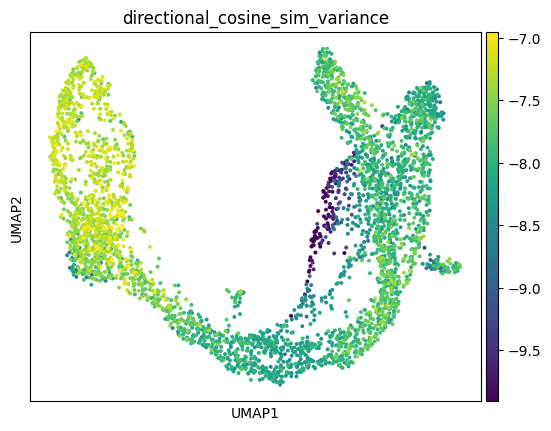

,directional_variance,directional_difference,directional_cosine_sim_variance,directional_cosine_sim_difference,directional_cosine_sim_mean
index,,,,,
AAACCTGAGAGGGATA,0.000042,0.017704,1.853639e-08,0.000326,0.999823
AAACCTGAGCCTTGAT,0.000055,0.021850,2.716147e-08,0.000442,0.999823
AAACCTGAGGCAATTA,0.000026,0.017798,9.610241e-09,0.000339,0.999846
AAACCTGCATCATCCC,0.000086,0.028108,6.519699e-08,0.000720,0.999675
AAACCTGGTAAGTGGC,0.000023,0.015098,6.850345e-09,0.000243,0.999892


In [10]:
uncertainty_df, _ = model.get_directional_uncertainty(adata, n_samples=100)
uncertainty_df.head()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 492 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 1132 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 1548 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 2028 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2572 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:  1.9min finished


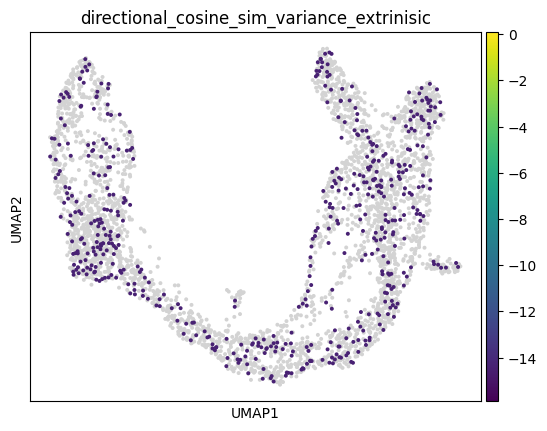

,directional_variance,directional_difference,directional_cosine_sim_variance,directional_cosine_sim_difference,directional_cosine_sim_mean
0,0.0,0.0,0.000000e+00,0.0,1.0
1,0.0,0.0,0.000000e+00,0.0,1.0
2,0.0,0.0,0.000000e+00,0.0,1.0
3,0.0,0.0,0.000000e+00,0.0,1.0
4,0.0,0.0,0.000000e+00,0.0,1.0
...,...,...,...,...,...
3691,0.0,0.0,0.000000e+00,0.0,1.0
3692,0.0,0.0,3.552714e-15,0.0,1.0
3693,0.0,0.0,0.000000e+00,0.0,1.0
3694,0.0,0.0,0.000000e+00,0.0,1.0


In [ ]:
df model.compute_extrinisic_uncertainty(
    adata,
    n_samples=25, 
    n_jobs=-1,
    show_plot=True)